In [50]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function

import pydrake # Make sure to import pydrake BEFORE torch!
from networks import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple network forward pass

In [51]:
from NNSystem import NNSystem
from pydrake.all import BasicVector

# Create nn and NNSystem
net = MLP(n_inputs=2, h_sz=8)
nn_system = NNSystem(net)

# Fix an input
context = nn_system.CreateDefaultContext()
context.FixInputPort(0, BasicVector([0, 0]))

# Get an output
output = nn_system.AllocateOutput()
nn_system.CalcOutput(context, output)
output_value = output.get_vector_data(0)

print(output_value)

[-0.141666]


# Declaring Params in Context (double and AutoDiffXd)

In [52]:
from NNSystem import NNSystem_
from pydrake.all import BasicVector_, AutoDiffXd

np.random.seed(1)

# T = float
T = AutoDiffXd

def rand():
    global T
    val = np.random.random()
    if T == float:
        return val
    elif T == AutoDiffXd:
        return AutoDiffXd(val, [1, 0])

# Create nn and NNSystem
net = MLP(n_inputs=2, h_sz=8)
nn_system = NNSystem_[T](net)

# Expose the networks params
params = np.array([rand() for _ in range(105)])
nn_system.DeclareNetworkParameters(params)

# Fix an input
context = nn_system.CreateDefaultContext()
context.FixInputPort(0, BasicVector_[T]( [[rand()], [rand()]] ))
output = nn_system.AllocateOutput()

# Get an output
nn_system.CalcOutput(context, output)
output_value = output.get_vector_data(0).CopyToVector()
print(output_value)

# Change network params
params = context.get_numeric_parameter(0)
for i in range(50):
    params.SetAtIndex(i, 1000*rand())

# Get an output
nn_system.CalcOutput(context, output)
output_value = output.get_vector_data(0).CopyToVector()
print(output_value)

[<AutoDiffXd 5.05596100896 nderiv=2>]
[<AutoDiffXd 5.10211246411 nderiv=2>]


# Network as a Controller

In [55]:
from demos.nn_policy import NNTestSetupPendulum, NNTestSetupAcrobot

kNetConstructor = lambda: MLP(n_inputs=2, h_sz=8)
net = kNetConstructor()
net.load_state_dict(torch.load('demo_net.pth'))
NNTestSetupPendulum(network=net, real_time_rate=1.0, isIpython=True)

# Testing Costs and Constraints

/home/rverkuil/integration/integration/lib/python2.7/site-packages/ipykernel_launcher.py:6: DrakeDeprecationWarning: MathematicalProgram methods that assume the solution is stored inside the program are deprecated; for details and porting advice, see https://github.com/RobotLocomotion/drake/issues/9633.  This method will be removed on 2019-06-01.
    Please see `help(pydrake.common.deprecation)` for more information.
  


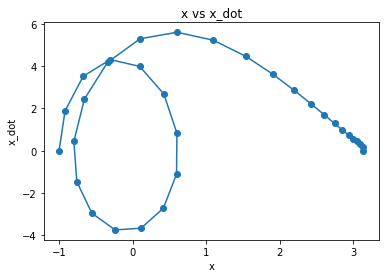

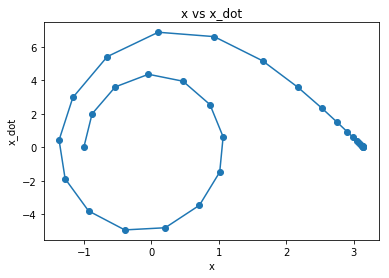

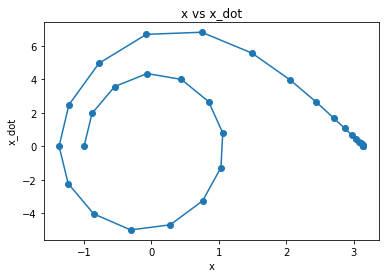

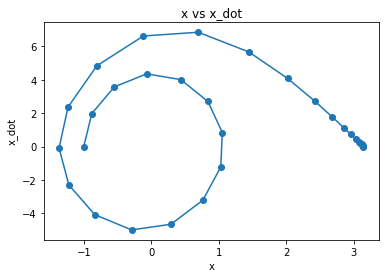

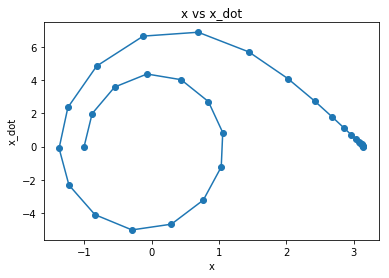

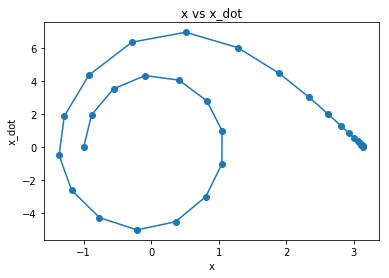

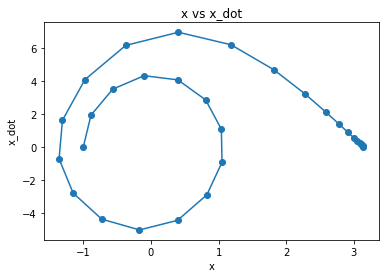

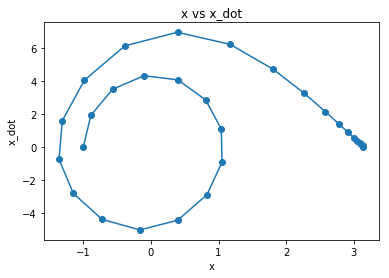

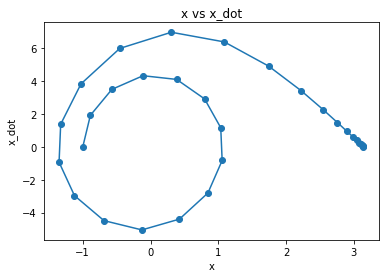

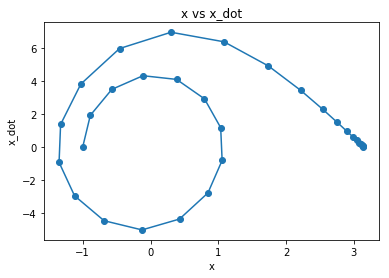

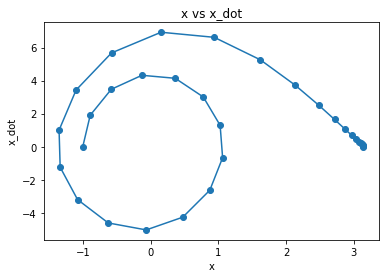

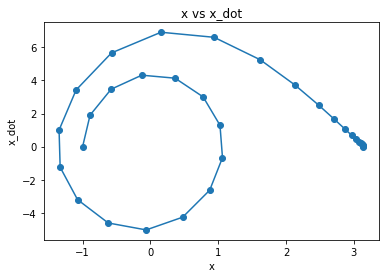

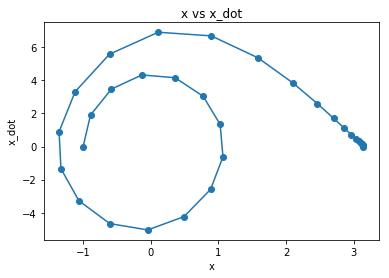

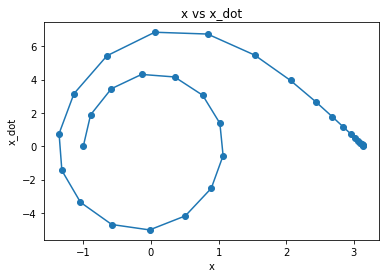

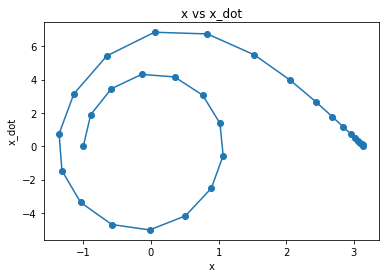

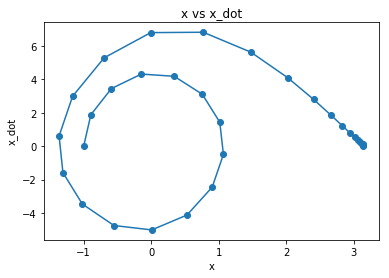

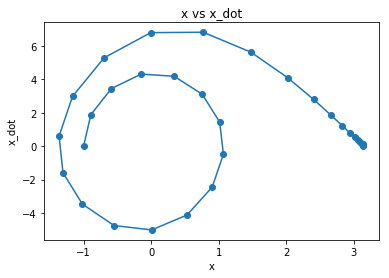

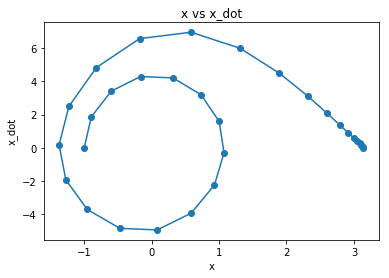

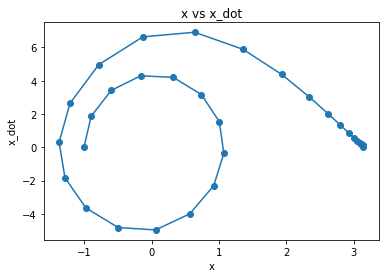

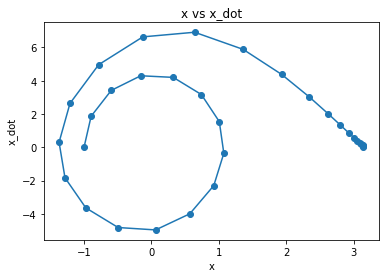

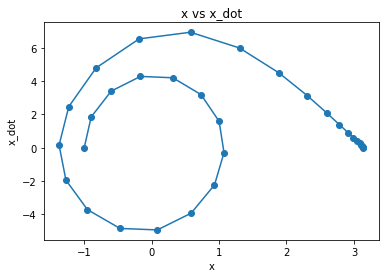

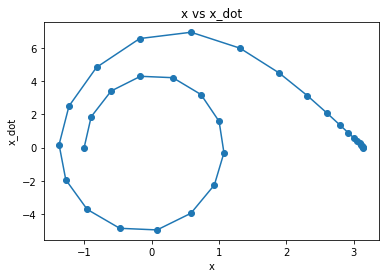

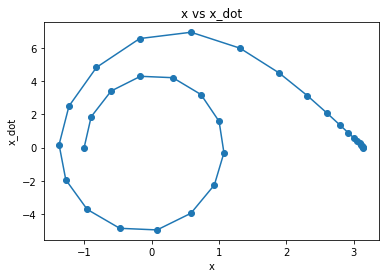

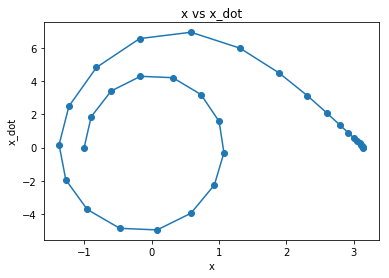

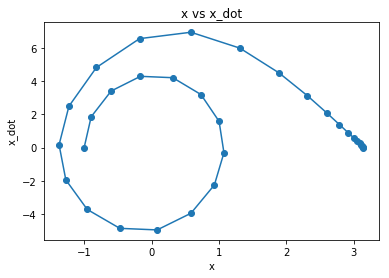

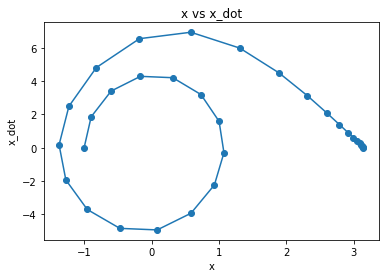

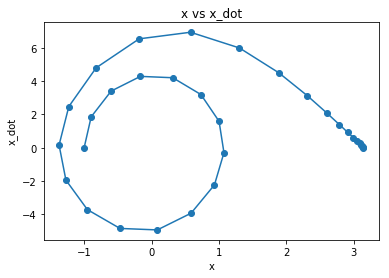

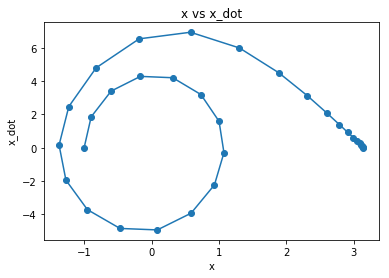

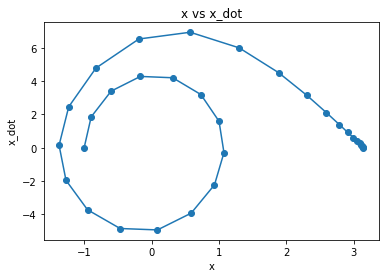

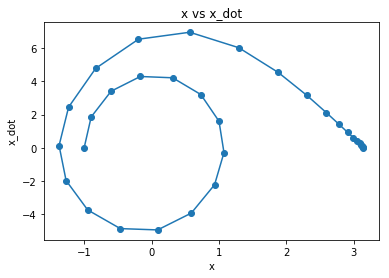

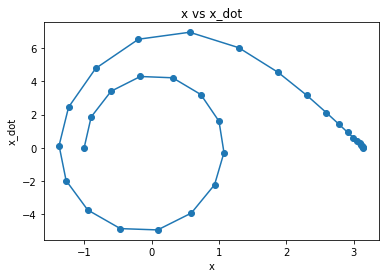

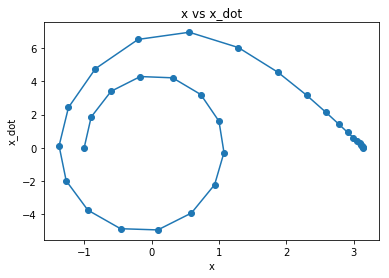

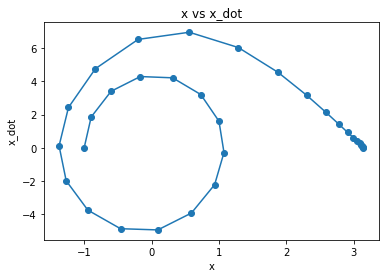

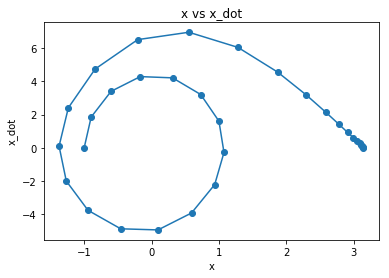

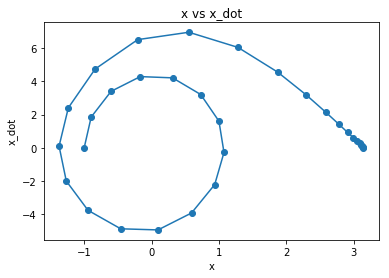

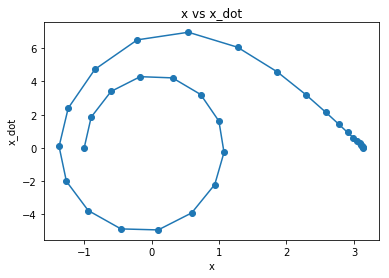

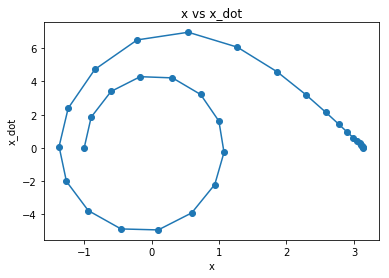

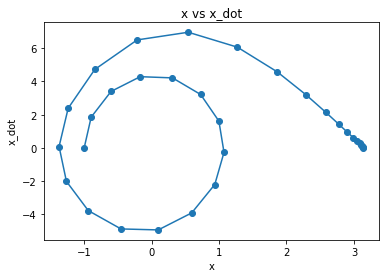

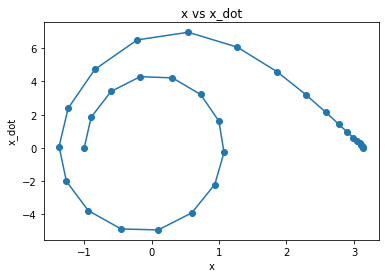

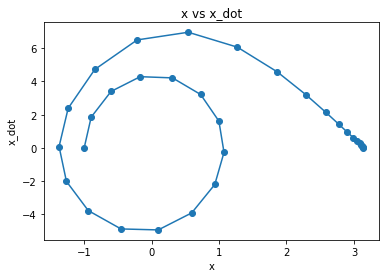

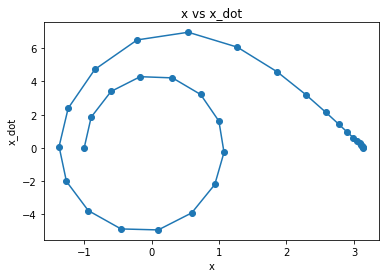

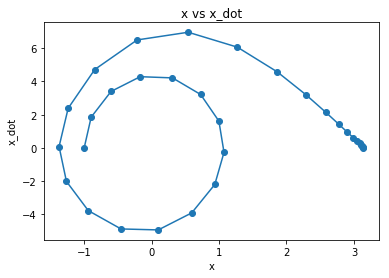

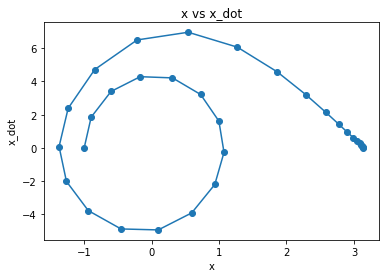

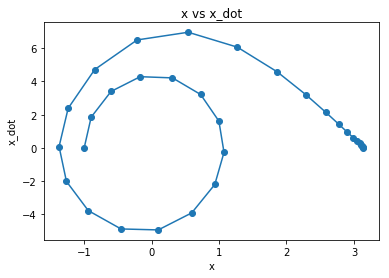

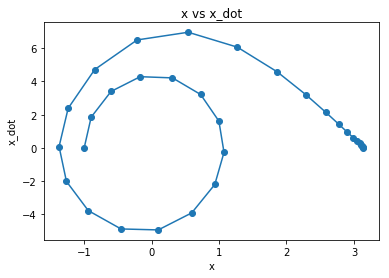

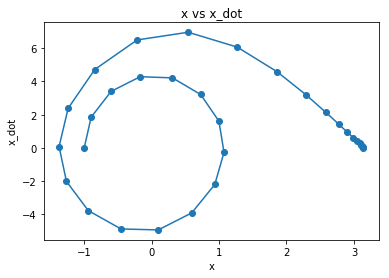

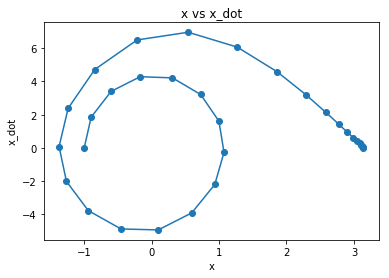

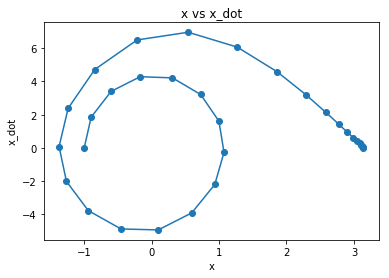

SolutionResult.kSolutionFound

In [54]:
% matplotlib inline
from demos.nn_costs_and_constraints import make_constrained_opt

kNetConstructor = lambda: FC(2)
dircol = make_constrained_opt(kNetConstructor, use_cost=True, use_constraint=False)
dircol.Solve()